### Project Description 
Recommend similar apparel products in e-commerce using product descriptions and Images

### Plan of Action 
* Data acquistion 
* Data Cleaning 
* Text preprocessing 
 * Stemming 
* Text Based Product Similiarity 
 * Bag of words on product Titles 
 * TF-IDF based product similarity 
 * IDF based product similarity
* Text Semantics based product similarity 
 * average word2Vec product similarity 
 * IDF weighted word3Vec for prodcut similarity 
 * weighted similarity using brand and color 
* Keras & Tensorflow to extract features 
 * Visual features based product similarity 




In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_json('/kaggle/input/amazon-fashion-dataset/tops_fashion.json')

In [4]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

Number of data points :  183138 Number of features/variables: 19


In [5]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

Each product/item has 19 features in the raw dataset.
Out of 19 features we are using 
1. asin ( Amazon standard identification number) 
2. brand ( brand to which the product belongs to ) 
3. color ( Color information of apparel, it can contain many colors as a value ex: red and black stripes ) 
4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT ) 
5. medium_image_url ( url of the image )
6. title (title of the product.) 
7. formatted_price (price of the product)

In [6]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]


In [7]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

Number of data points :  183138 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


### Finding Missing values for the features

#### Basic stats for the feature - product_type_name

In [8]:
print(data['product_type_name'].describe())



count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [9]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [10]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)


[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

#### Brand

In [11]:
print(data['brand'].describe())

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [12]:
product_type_count = Counter(list(data['brand']))
product_type_count.most_common(10)

# 183138 - 182987 = 151 missing values.

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

#### color

In [13]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [14]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

# 64956 of 183138 products have color information.

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

#### formatted_price

In [15]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [16]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### title

In [17]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [18]:
# consider products which have price information
# data['formatted_price'].isnull() => gives the information 
#about the dataframe row's which have null values price == None|Null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])


Number of data points After eliminating price=NULL : 28395


In [19]:
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])


Number of data points After eliminating color=NULL : 28385


In [20]:
print(sum(data.duplicated('title')))

2325


There are many duplicate products, we need to de-dupe them for better results.

## Removing duplicates

### Remove duplicates : part 1 

In [21]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [22]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [23]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


In [24]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)
import itertools    
stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)


KeyboardInterrupt: 

In [ ]:
data = pd.read_pickle('C:/Users/himaj/OneDrive/Documents/AmazonFashionReviews/AmazonProductRecommendation/pickels/17k_apparel_data')


In [25]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'for', 'his', 'they', "mustn't", 'when', 'a', 'any', 'my', "should've", 'myself', 'been', 'your', 'were', 'd', 'shouldn', 'mightn', 'i', 'not', 'll', 'as', 'through', 'out', 'did', "it's", 'has', 'other', 'can', 'weren', 've', 'that', 'now', "hadn't", "wouldn't", 'doing', 'up', 'hadn', 'once', 'me', 'o', 'against', 'what', 'couldn', 'theirs', 'very', 'under', 're', 'to', 'y', 'him', "wasn't", 'hers', 'each', 'the', 'was', 'we', 'wasn', 'who', 'shan', "mightn't", 'too', 't', 'had', "couldn't", 'an', 'why', 'it', 'no', 'are', 'do', 'them', 'these', 'or', 'before', "weren't", 'wouldn', 'himself', 'does', 'down', 'its', 'won', 'yourselves', 'few', 'is', 'nor', "you're", 'only', 'below', 'this', 'just', 'with', 'ma', 'further', 'will', 'don', 'aren', 'over', 'by', 'he', "you've", 'which', "you'd", 'but', 'themselves', 'those', "haven't", 'there', 'ain', 'at', 'their', 'during', 'on', "needn't", 'into', 'doesn', 'whom', "hasn't", 'both', 'didn', 'such', 'about', "shan't"

In [26]:
import time 
start_time = time.time()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.time() - start_time, "seconds")

8.678198099136353 seconds


In [27]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,ladies cotton tank 2x1 ribbed tank top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel short sle...,$7.50


In [29]:
data.to_pickle('C:/Users/himaj/OneDrive/Documents/AmazonFashionReviews/AmazonProductRecommendation/pickels/16k_apperal_data_preprocessed')


In [28]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


argu
fish


In [30]:
data = pd.read_pickle('/kaggle/input/amazon-fashion-dataset/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
43,B0079BMKDS,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,APPAREL,featherlite ladies silky smooth pique white xl,$13.53


### Text based product similarity

In [31]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

#we plot the code to understand algorithm's decision

#keys: list of words of recommended title 
#values: values(i) represent the occurrences of word key(i)
# labels : the values of labels depends on the model we are using
# if model == 'bag of words': labels(i) = values(i)
# if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
# if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
# url : apparel's url 
# we will divide the whole figure into two parts
# 1st, ploting heat map that represents the count of commonly ocurred words in title2

def plot_heatmap(keys, values, labels, url, text):
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
    fig = plt.figure(figsize=(25,3))
    ax = plt.subplot(gs[0])
    # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
    ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
    ax.set_xticklabels(keys) # set that axis labels as the words of title
    ax.set_title(text) # apparel title
    # 2nd, plotting image of the the apparel
    ax = plt.subplot(gs[1])        # we don't want any grid lines for image and no labels on x-axis and y-axis
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # we call dispaly_img based with paramete url
    display_img(url, ax, fig)
        
    # displays combine figure ( heat map and image together)
    plt.show()
        
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf
    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys())&set(vec2.keys())
    
    # we set the values of non intersecting words to zero, this is just to show the difference in the heatmap
    
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
            
    #for labelling heatmap, keys contain list of all words in title2
    keys = list(vec2.keys())
    
    #if ith word in intersection(list of words of title1 and title2)
    values = [vec2[x] for x in vec2.keys()]
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)
    
# this function gets a list of words along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}


def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)
    

### Bag of words (BoW) on product titles

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(17592, 12927)

title_features.shape = #data_points * #words_in_corpus
CountVectorizer().fit_transform(corpus) returns 
the a sparase matrix of dimensions data_points * words_in_corpus

What is a sparse vector?

title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

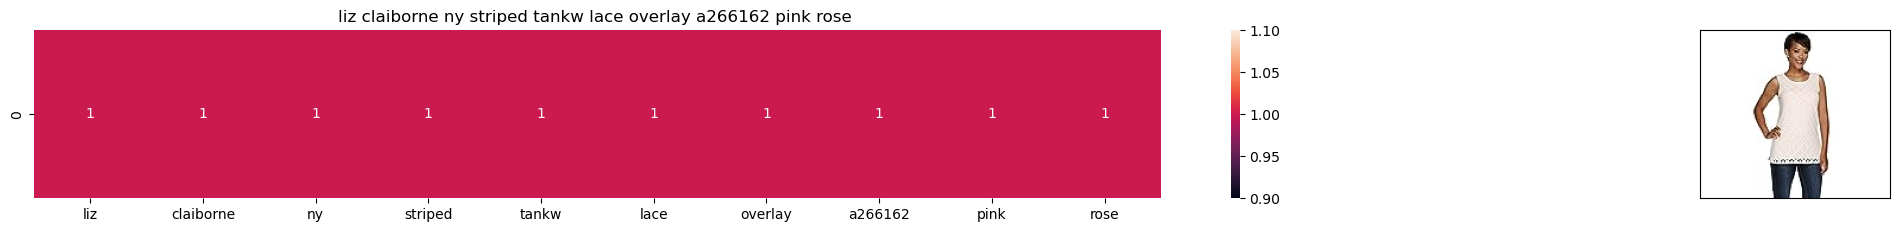

ASIN : B074WKZS37
Brand: Liz Claiborne New York
Title: liz claiborne ny striped tankw lace overlay a266162 pink rose 
Euclidean similarity with the query image : 0.0


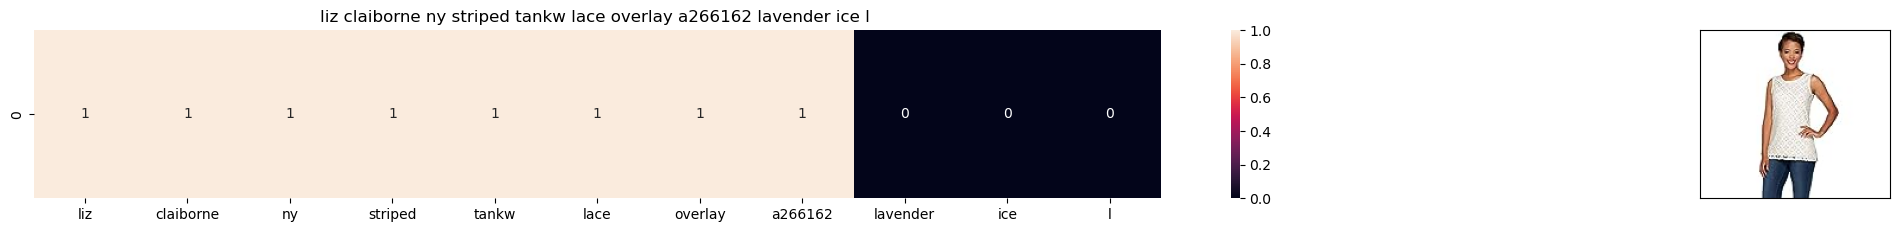

ASIN : B074WKNKHL
Brand: Liz Claiborne New York
Title: liz claiborne ny striped tankw lace overlay a266162 lavender ice l 
Euclidean similarity with the query image : 2.0


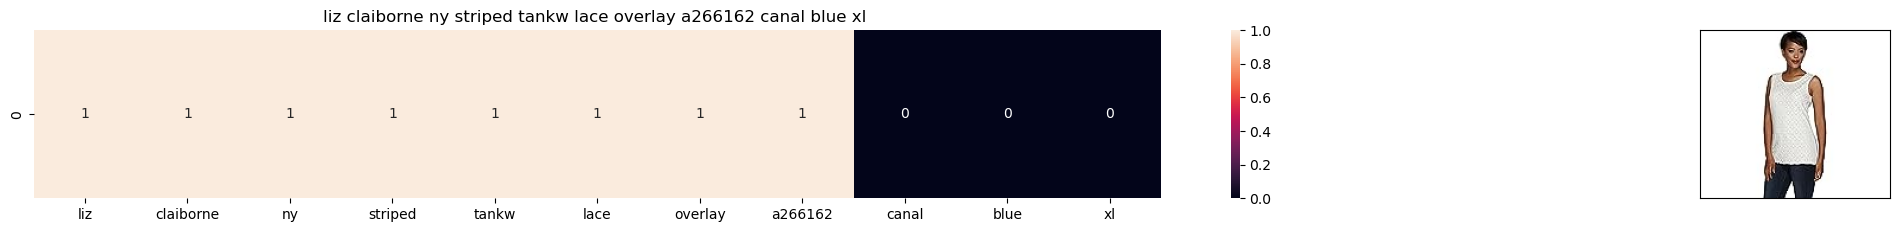

ASIN : B074WLVCTP
Brand: Liz Claiborne New York
Title: liz claiborne ny striped tankw lace overlay a266162 canal blue xl 
Euclidean similarity with the query image : 2.23606797749979


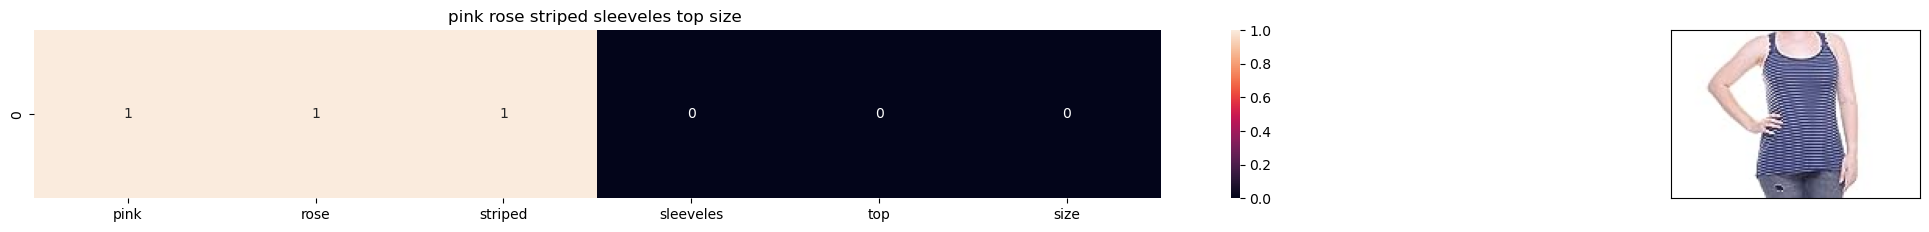

ASIN : B072BVDTNK
Brand: PINK ROSE
Title: pink rose striped sleeveles top size 
Euclidean similarity with the query image : 3.1622776601683795


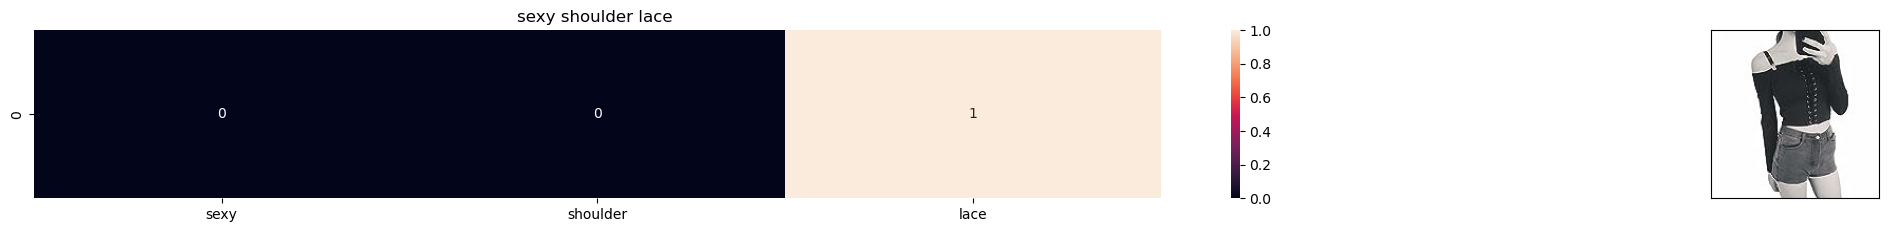

ASIN : B01JVWUB3S
Brand: bylexie
Title: sexy shoulder lace 
Euclidean similarity with the query image : 3.3166247903554


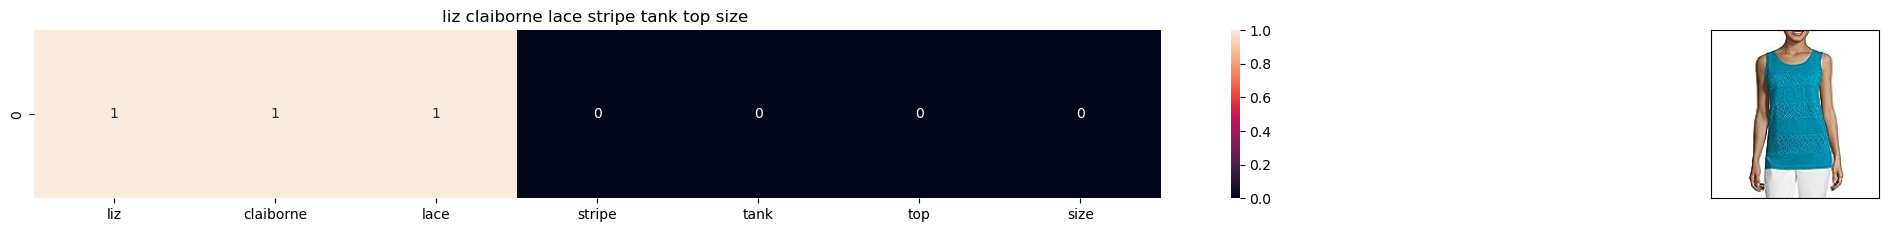

ASIN : B06XQVZWY4
Brand: Liz Claiborne
Title: liz claiborne lace stripe tank top size 
Euclidean similarity with the query image : 3.3166247903554


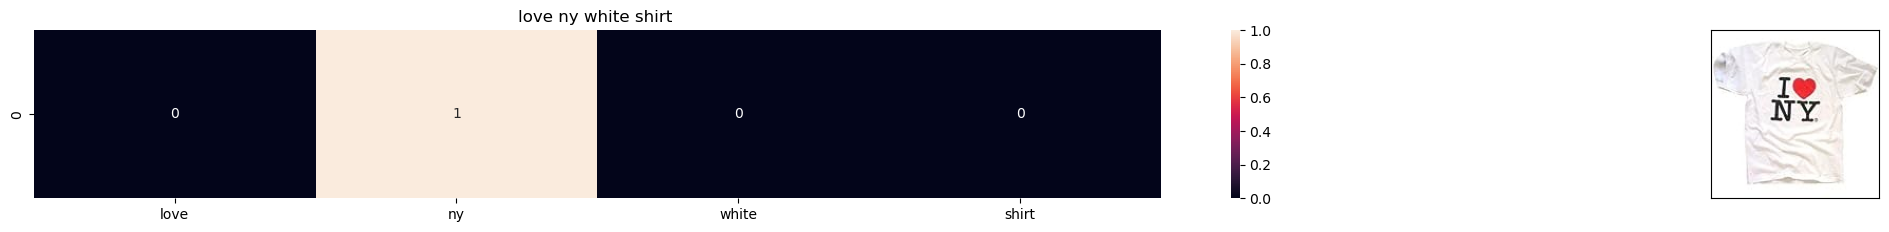

ASIN : B007N3WV6I
Brand: Forgot My Souvenirs
Title: love ny white shirt 
Euclidean similarity with the query image : 3.4641016151377544


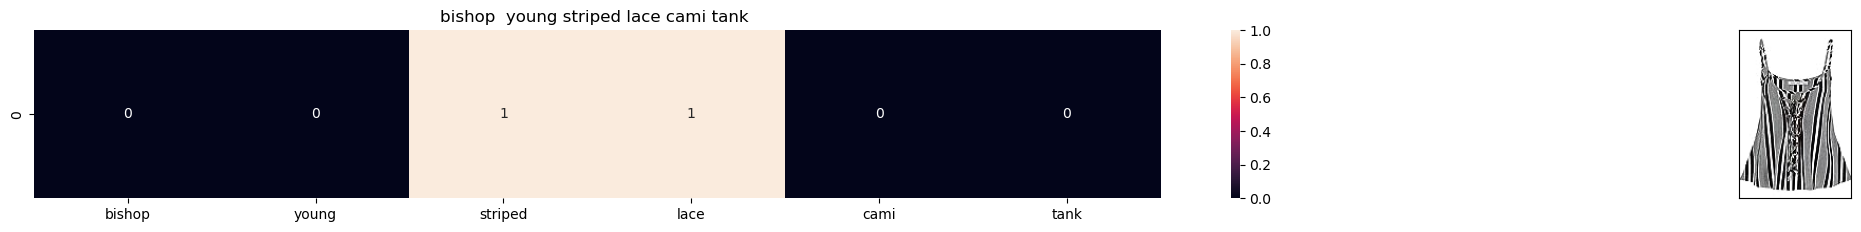

ASIN : B0742P259P
Brand: Bishop & Young
Title: bishop  young striped lace cami tank 
Euclidean similarity with the query image : 3.4641016151377544


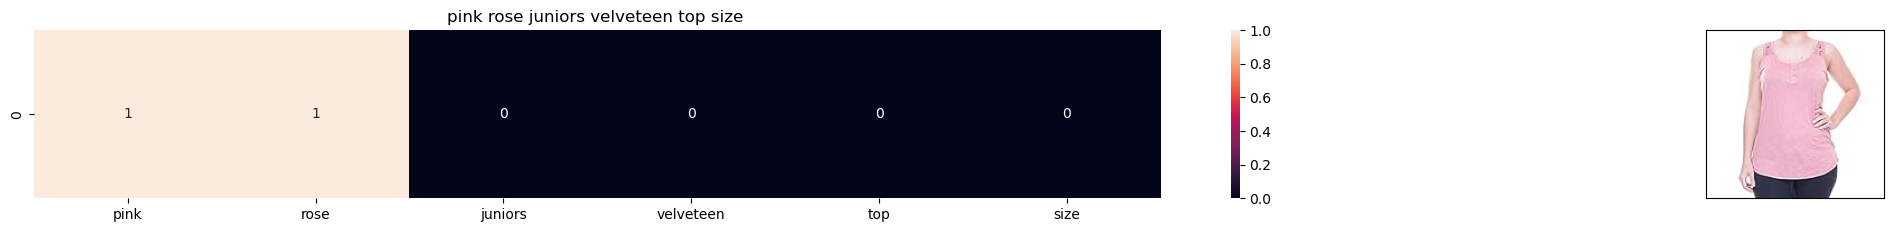

ASIN : B06XY6VVV3
Brand: PINK ROSE
Title: pink rose juniors velveteen top size 
Euclidean similarity with the query image : 3.4641016151377544


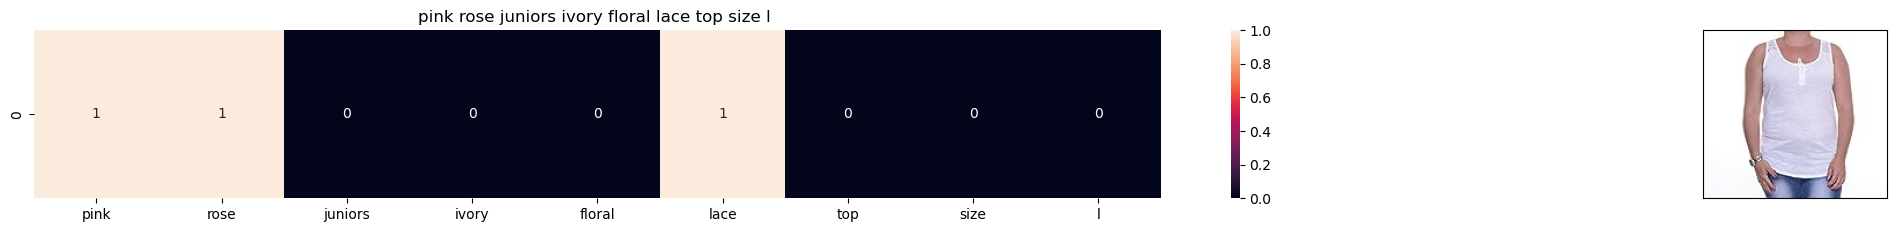

ASIN : B0716R4GP6
Brand: PINK ROSE
Title: pink rose juniors ivory floral lace top size l 
Euclidean similarity with the query image : 3.4641016151377544


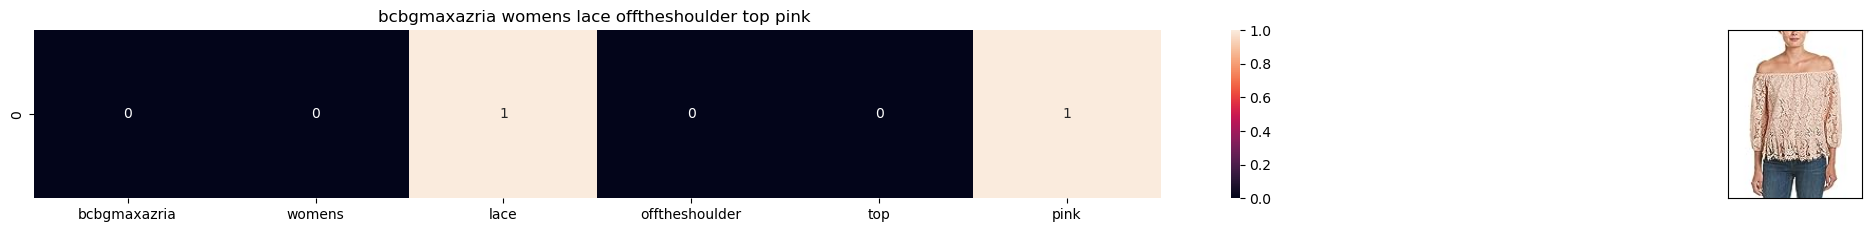

ASIN : B074TH83H1
Brand: BCBGMAXAZRIA
Title: bcbgmaxazria womens lace offtheshoulder top pink 
Euclidean similarity with the query image : 3.4641016151377544


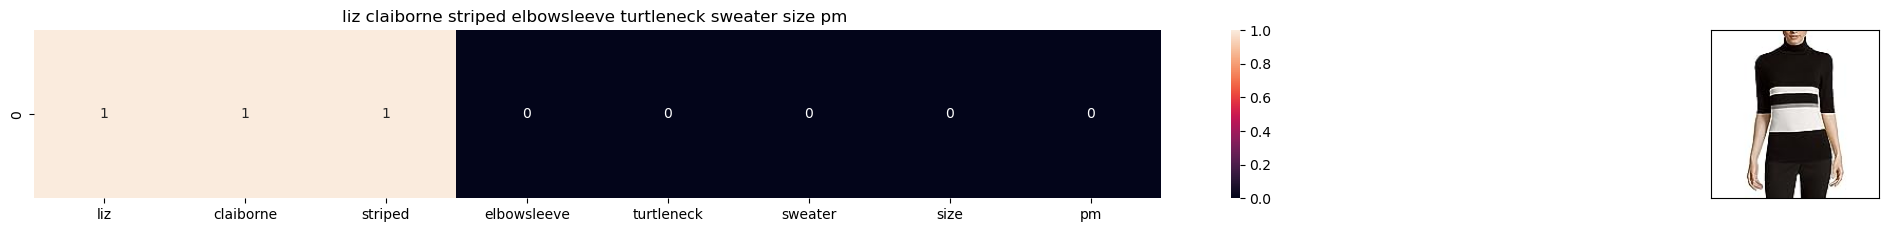

ASIN : B06Y4BN9KY
Brand: Liz Claiborne
Title: liz claiborne striped elbowsleeve turtleneck sweater size pm 
Euclidean similarity with the query image : 3.4641016151377544


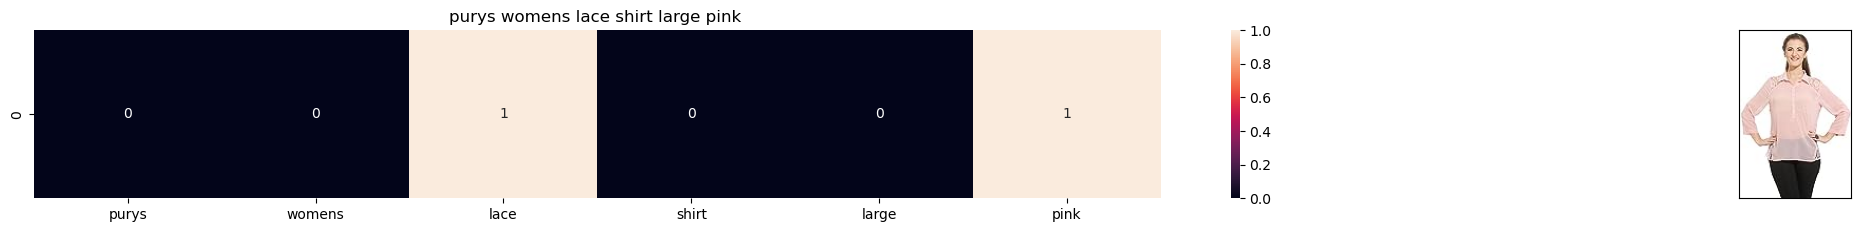

ASIN : B00X5ZS9NM
Brand: Purys
Title: purys womens lace shirt large pink 
Euclidean similarity with the query image : 3.4641016151377544


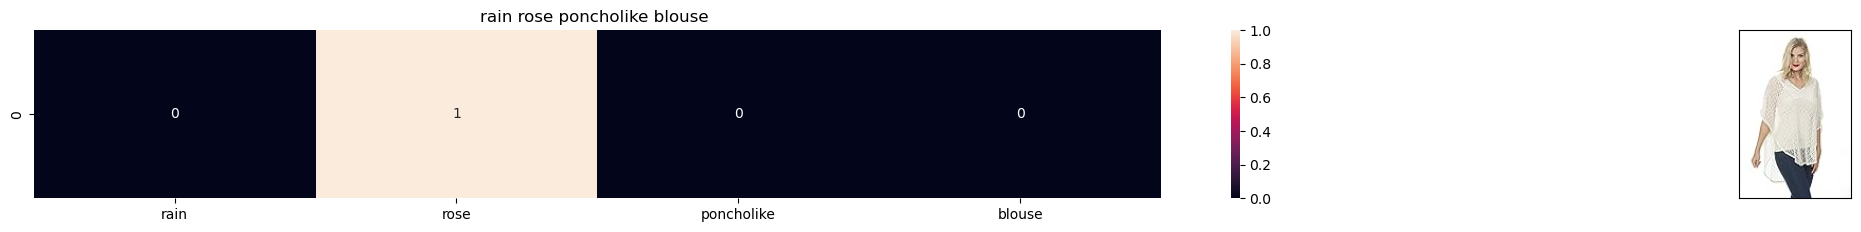

ASIN : B074JLMDR8
Brand: Rain
Title: rain rose poncholike blouse 
Euclidean similarity with the query image : 3.4641016151377544


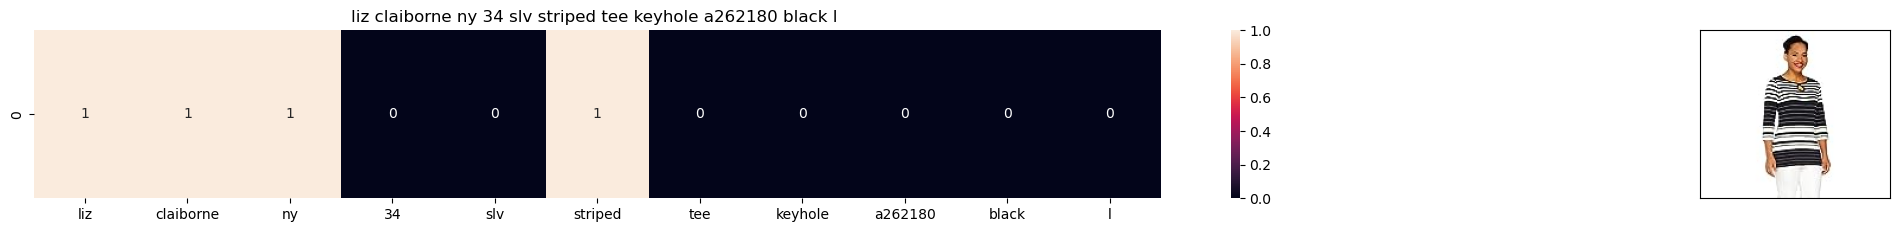

ASIN : B074WL13DQ
Brand: Liz Claiborne New York
Title: liz claiborne ny 34 slv striped tee keyhole a262180 black l 
Euclidean similarity with the query image : 3.4641016151377544


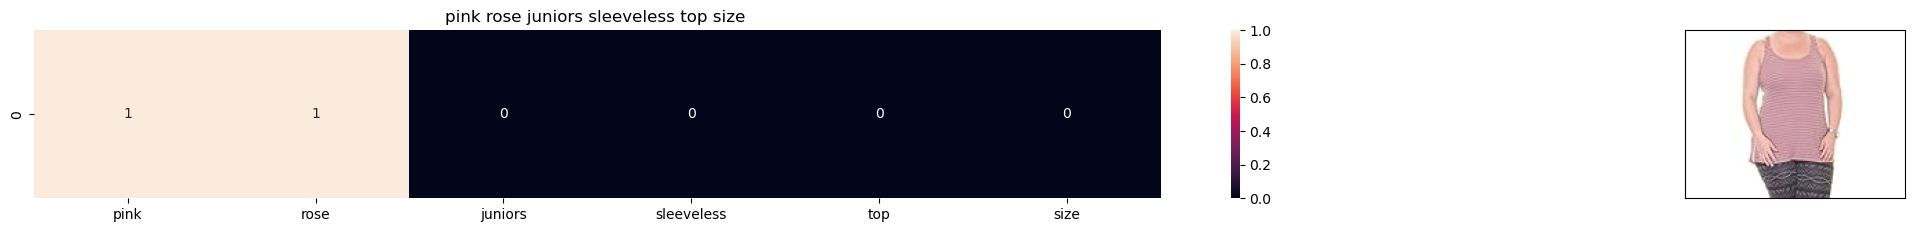

ASIN : B01MG5KJCQ
Brand: PINK ROSE
Title: pink rose juniors sleeveless top size 
Euclidean similarity with the query image : 3.4641016151377544


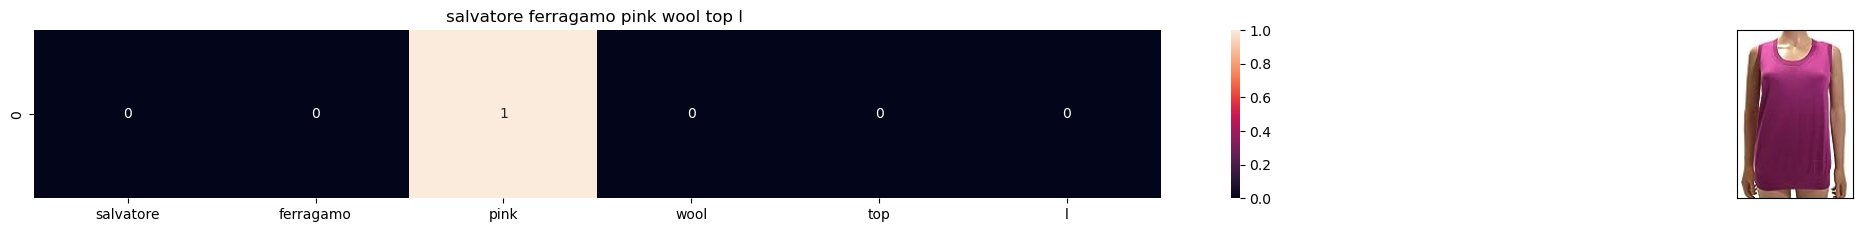

ASIN : B0756K4KNX
Brand: Salvatore Ferragamo
Title: salvatore ferragamo pink wool top l 
Euclidean similarity with the query image : 3.605551275463989


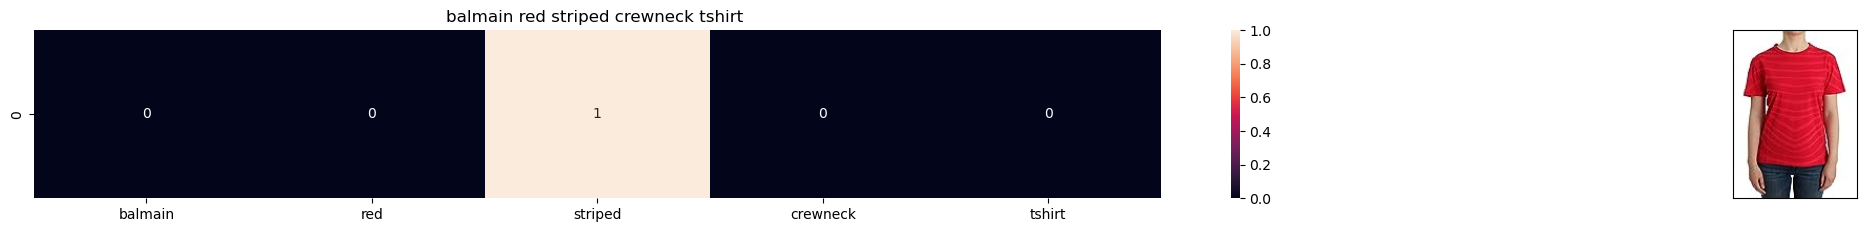

ASIN : B074G55DCV
Brand: Balmain
Title: balmain red striped crewneck tshirt 
Euclidean similarity with the query image : 3.605551275463989


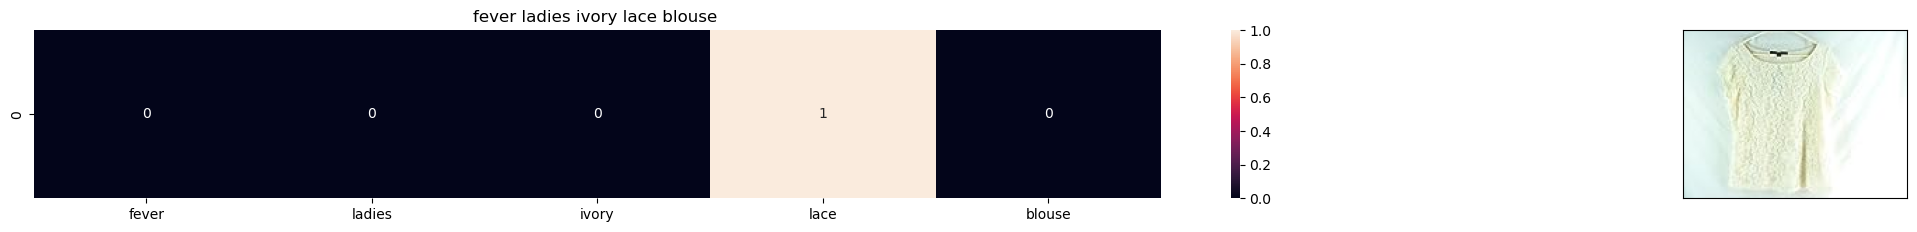

ASIN : B01M19KC7Q
Brand: Fever
Title: fever ladies ivory lace blouse 
Euclidean similarity with the query image : 3.605551275463989


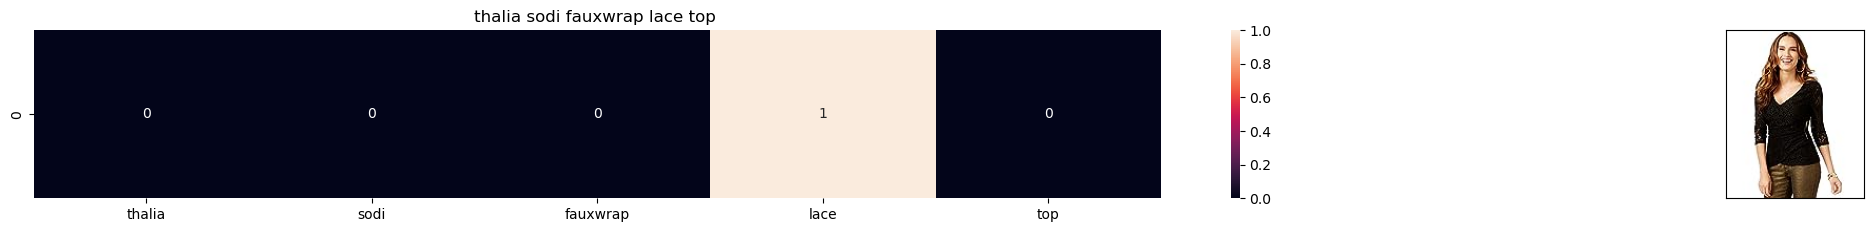

ASIN : B01KYG0M0C
Brand: Thalia
Title: thalia sodi fauxwrap lace top 
Euclidean similarity with the query image : 3.605551275463989


In [33]:
def bag_of_words_model(doc_id,num_results):
    #doc_id: apparel's id in given corpus
    #pairwise_dist will store the distance from given input apparel to all remaining apparels
    #the metric we used here is cosine, the cosine distance is measured as K(X,Y)=<X,Y>/(||x|*|y||)
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
bag_of_words_model(12567, 20)    

In [34]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc


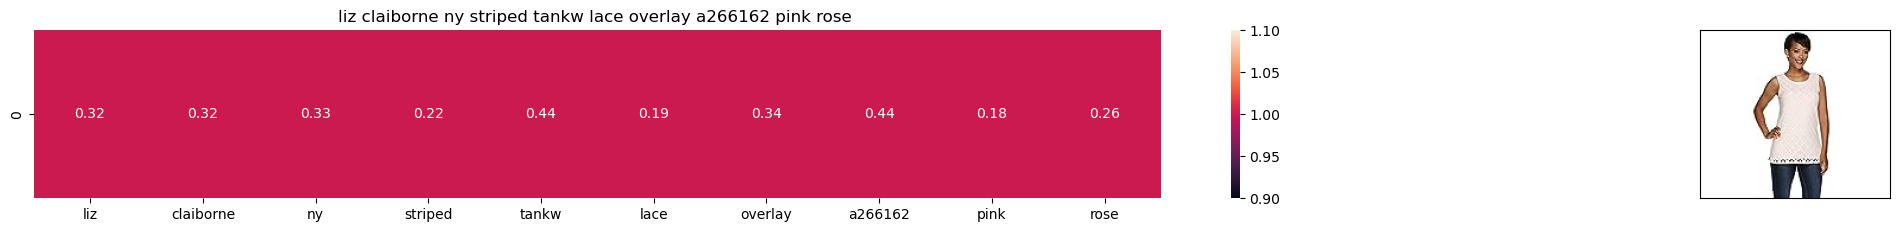

ASIN : B074WKZS37
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 0.0


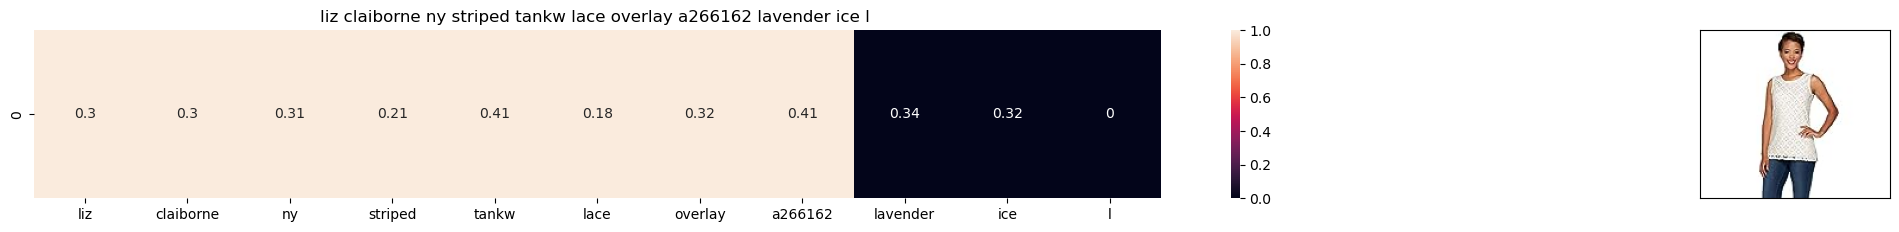

ASIN : B074WKNKHL
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 0.562300461944277


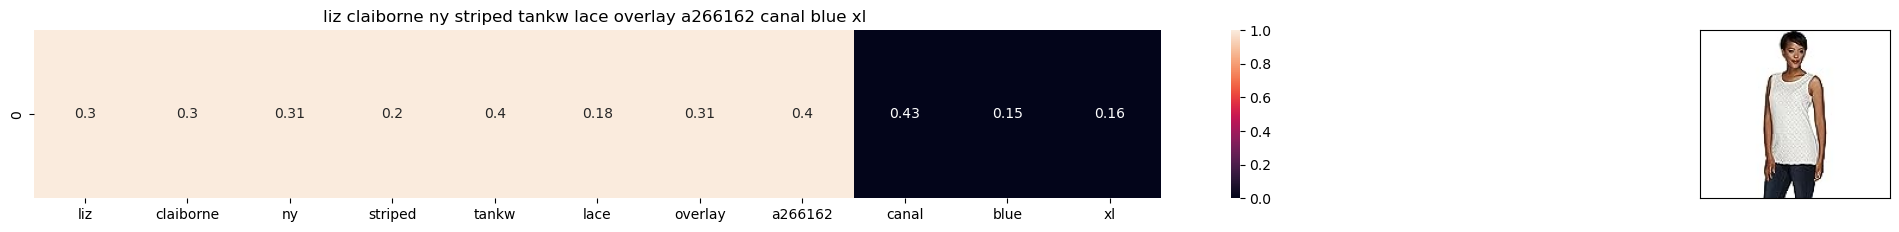

ASIN : B074WLVCTP
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 0.5822333186446346


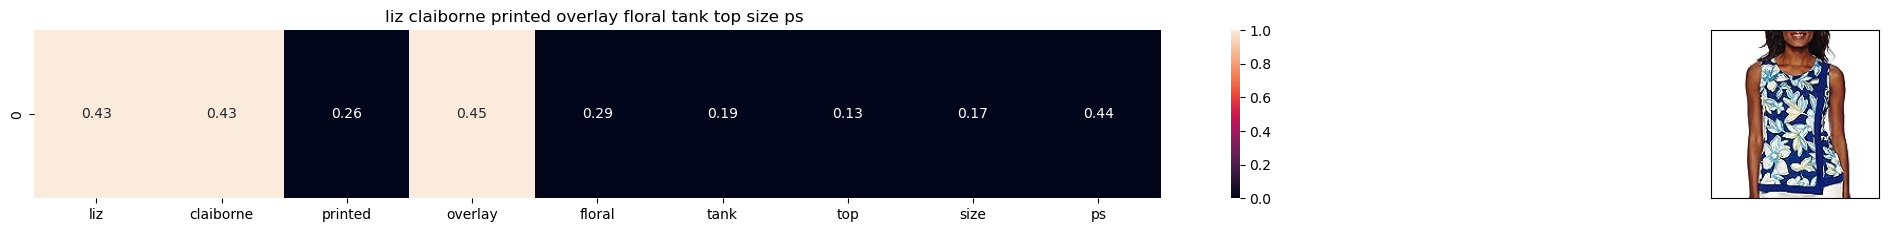

ASIN : B06XVK6KD3
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.0664196435440452


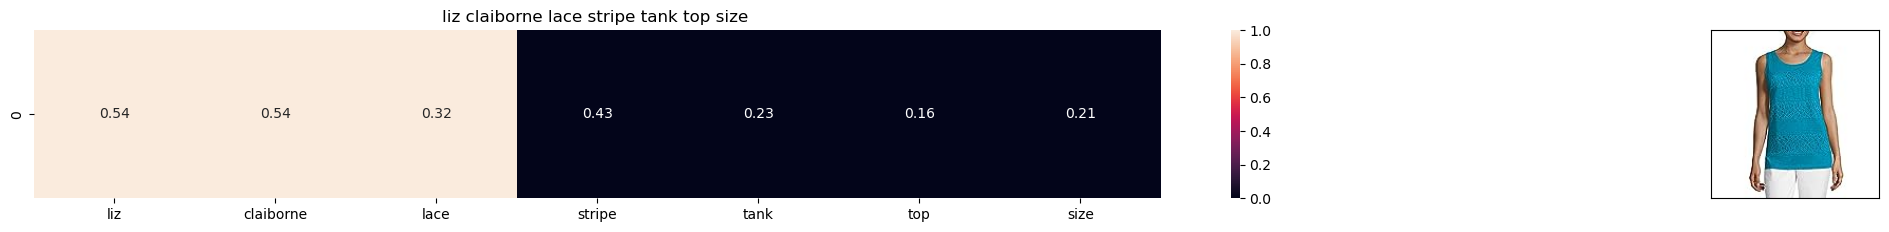

ASIN : B06XQVZWY4
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.084785292910814


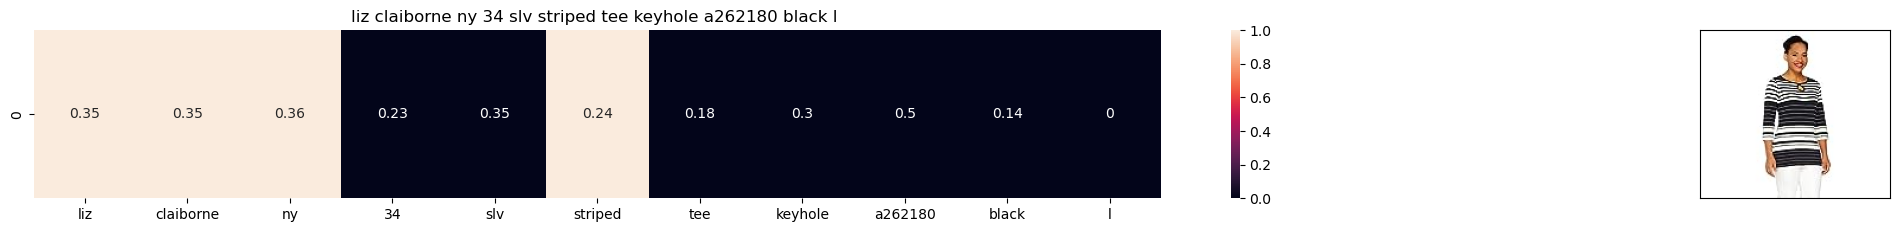

ASIN : B074WL13DQ
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.098263344467803


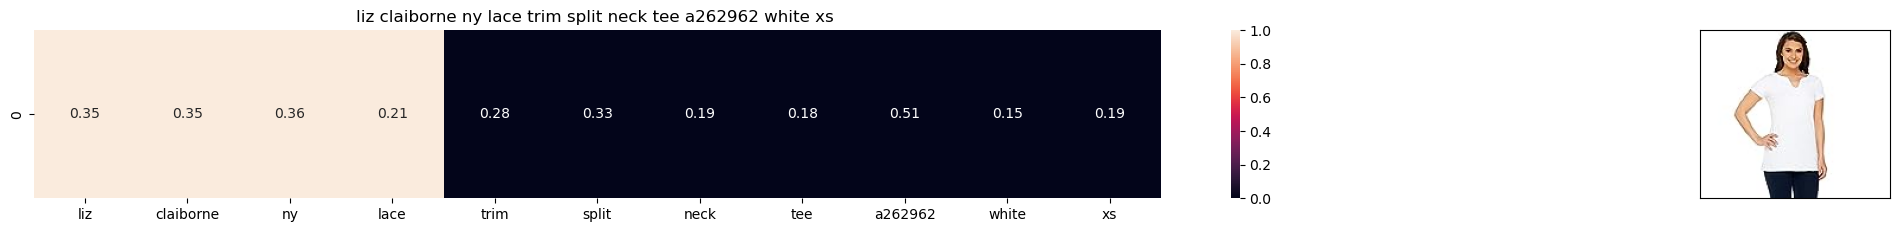

ASIN : B074X99PYW
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.1056618431718943


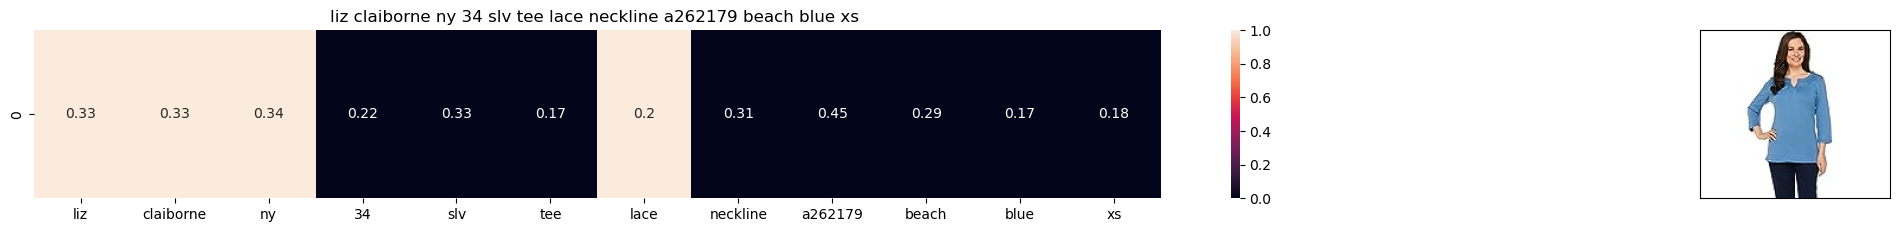

ASIN : B074XFRH9Y
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.1269332462320014


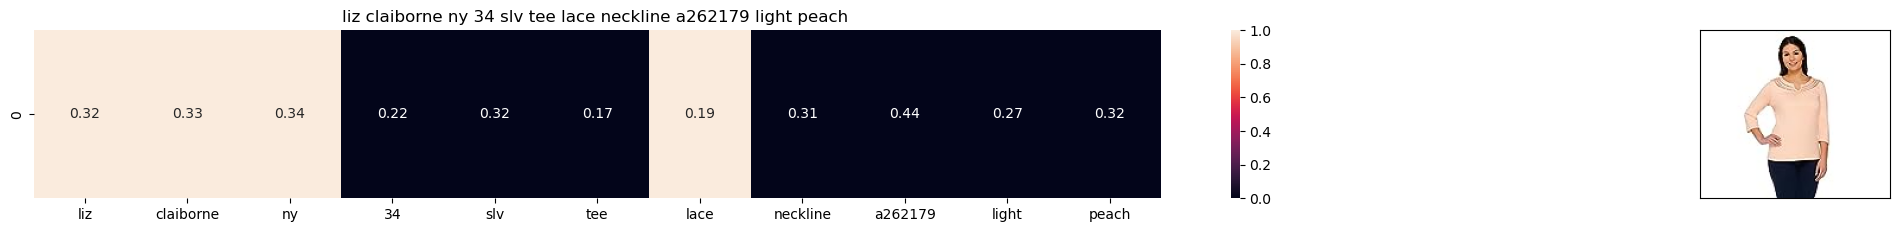

ASIN : B074WLQWF7
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.1317219916967038


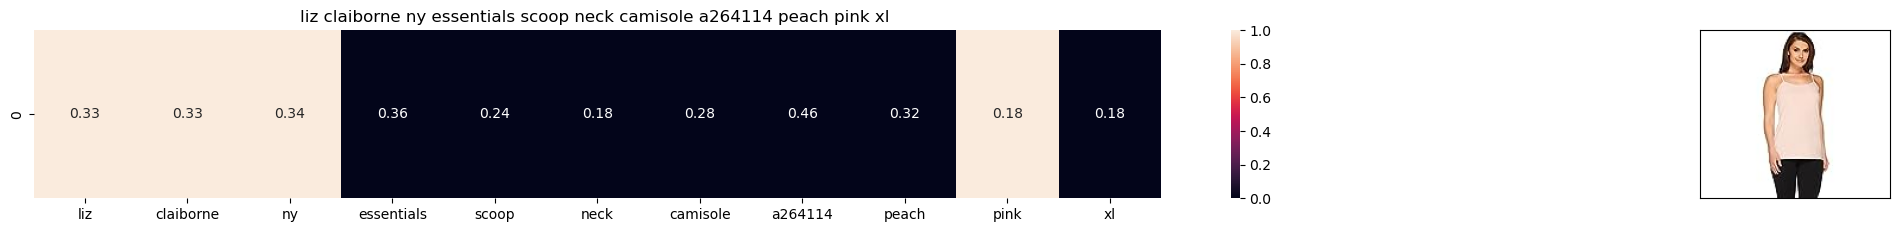

ASIN : B073NM1W7V
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.1333887092235349


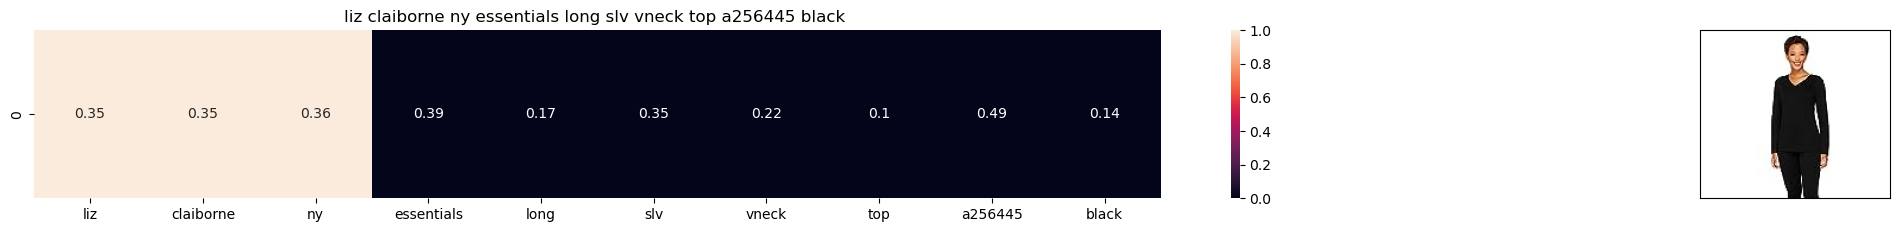

ASIN : B072XGXCK4
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.140788008300148


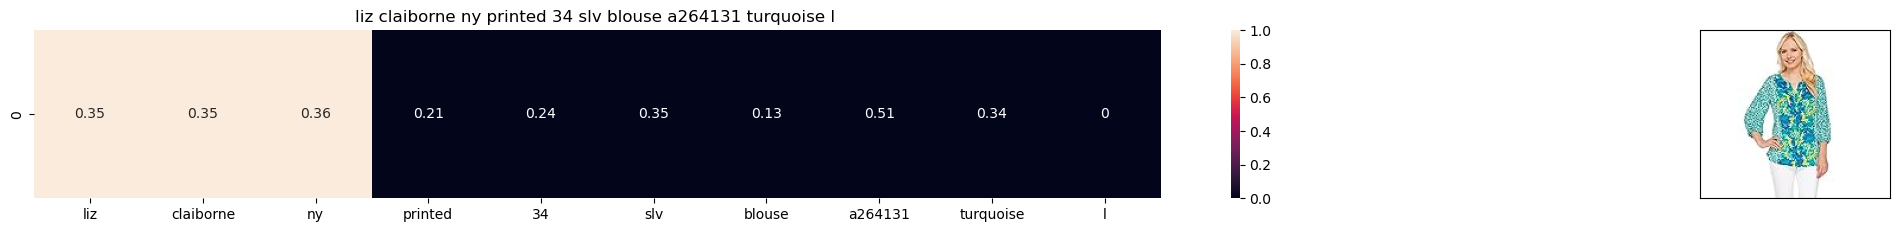

ASIN : B074WK4XLY
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.140805685528012


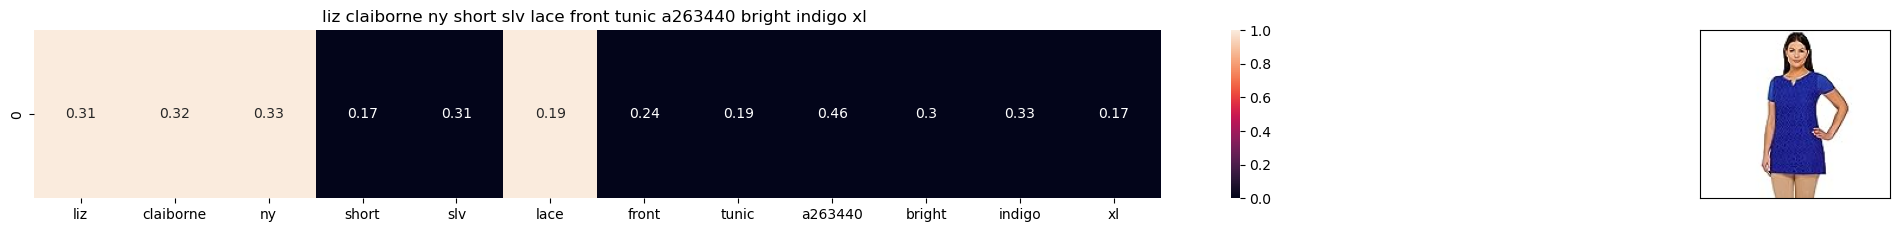

ASIN : B074WKYKD6
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.1414781149559354


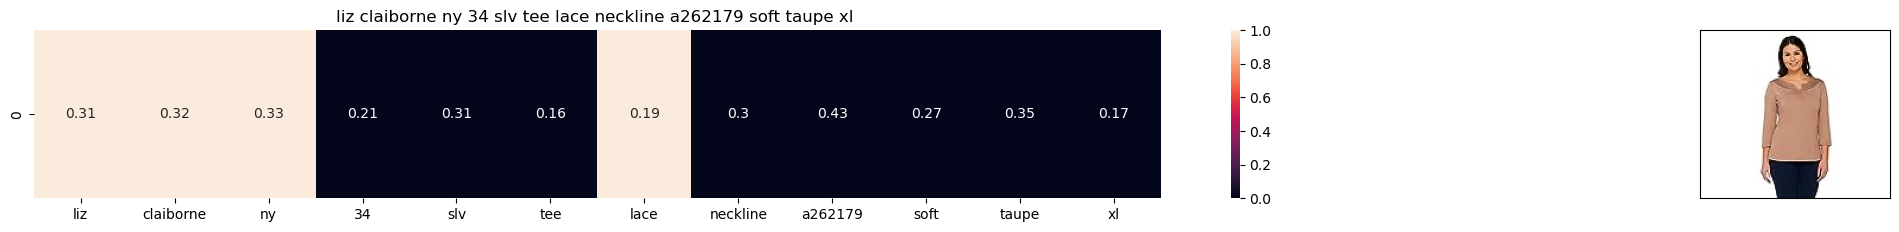

ASIN : B074WLWVVQ
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.1418026451979832


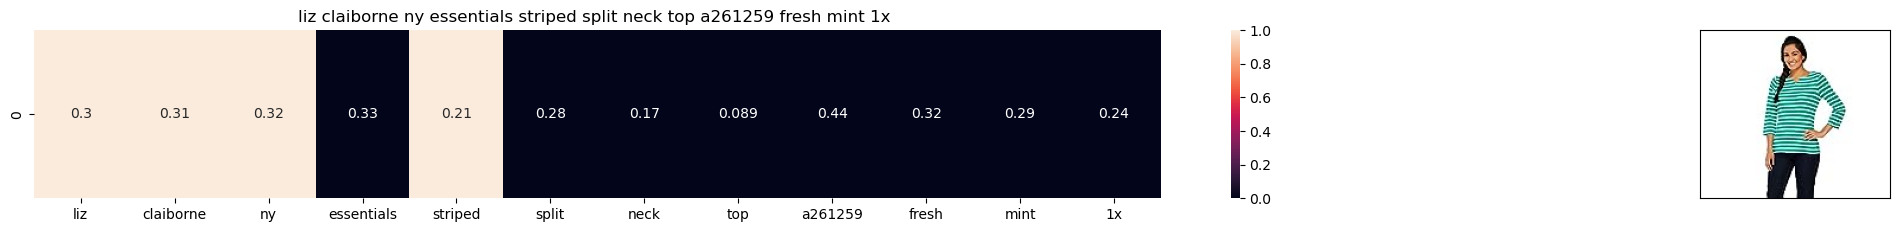

ASIN : B07533SXXN
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.142126858135849


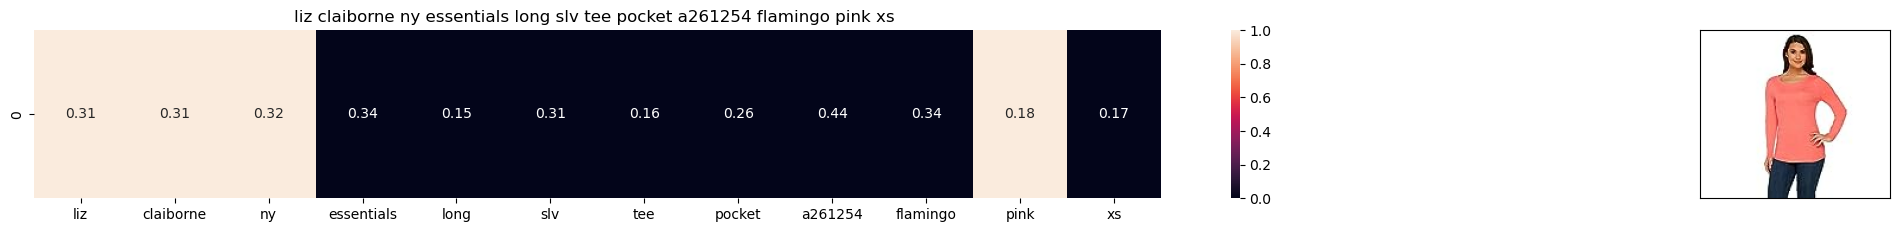

ASIN : B074XC1SDM
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.1471682642234615


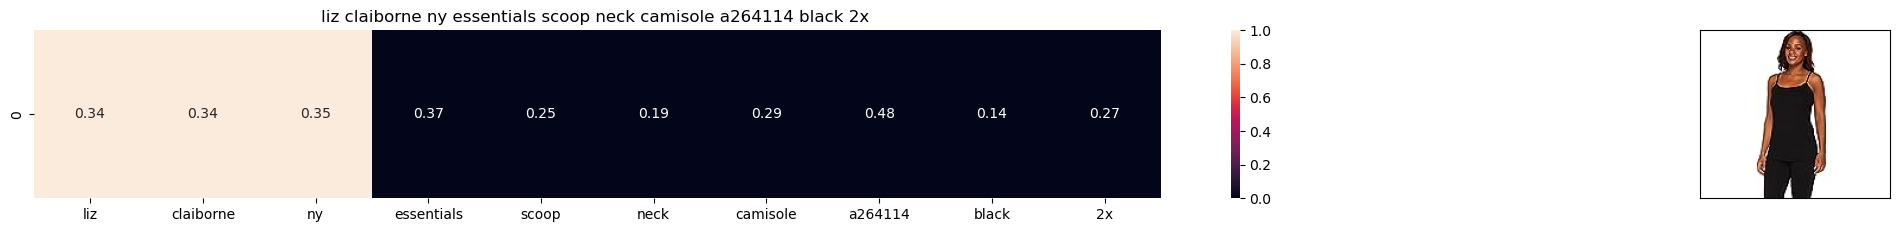

ASIN : B074WKW41H
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.149939124919152


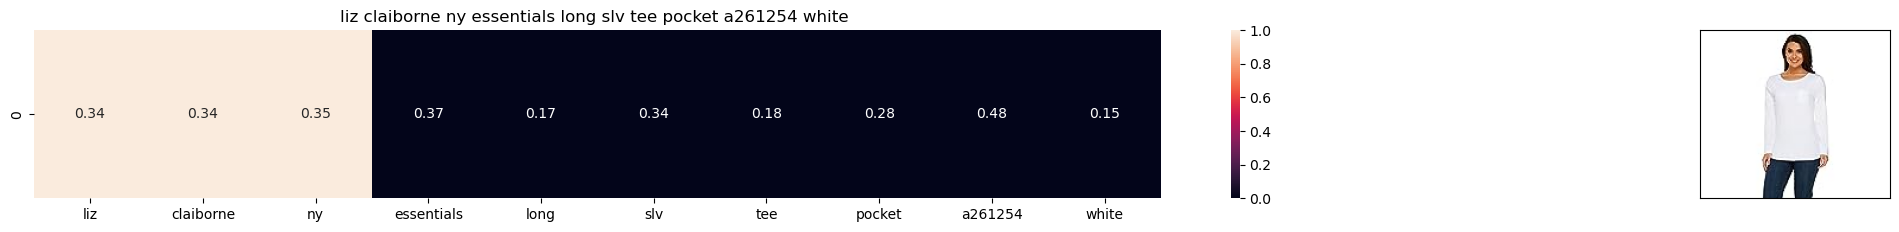

ASIN : B074WJ67R8
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.1502424982078943


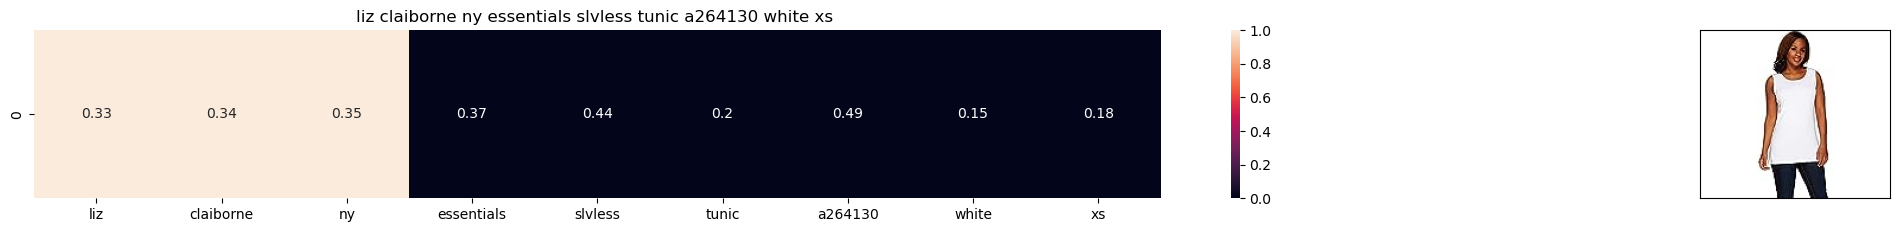

ASIN : B074XHSM2N
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.1564500517596492


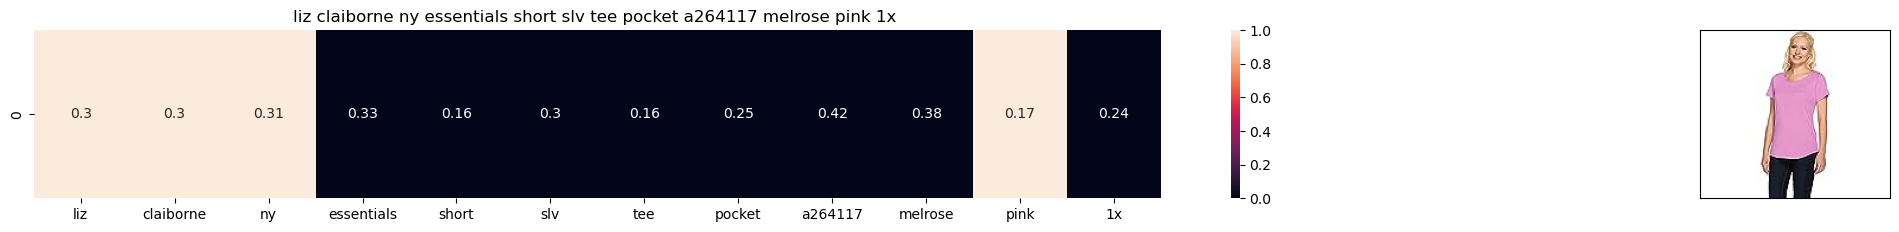

ASIN : B074WL4NKV
BRAND : Liz Claiborne New York
Eucliden distance from the given image : 1.1572918315824812


In [35]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12567, 20)

In [36]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])


In [37]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [ ]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

In [ ]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12567,20)